<a href="https://colab.research.google.com/github/thdefn/Detector/blob/main/trs_learning_ver_non_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG19 전이학습 Augumentation 사용안한 버전



In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical
import pickle

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My Drive/data/.kaggle

/content/gdrive/My Drive/data/.kaggle


In [ ]:
root_dir = './'
train_dir = os.path.join(root_dir,'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')


added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

In [ ]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

In [ ]:
'''t = ImageDataGenerator(rescale=1./ 255, 
                       rotation_range = 40,
                        zoom_range = 0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        horizontal_flip = True,
                        vertical_flip = True)'''

t = ImageDataGenerator(rescale=1./ 255, rotation_range=0.3, zoom_range=0.3)

t_gen = t.flow_from_dataframe(files_df,x_col='filepath', y_col='label', target_size = (128, 128),batch_size=16,class_mode='categorical', color_mode='rgb', subset='training')

In [ ]:
# valid를 위한 nongen
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (128, 128), class_mode='categorical', color_mode='rgb', subset='validation')

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
# 사전 교육된 기본 모델 가져오기
base_model = VGG19(include_top=False, weights='imagenet',input_shape=(128, 128, 3))

base_model.trainable = False

# 교육할 계층 설정 최상위 계층만 교육하기 위해 (False 가중치 고정)
for layer in base_model.layers:
    layer.trainable = False
    
# 기본 모델의 마지막 층
x = base_model.output

x = Flatten()(x)
h1 = Dense(512, activation='relu')(x)
drop1 = Dropout(rate=0.5)(h1)
h2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(rate=0.5)(h2)
output = Dense(3, activation='softmax')(drop2)

trs = Model(inputs=base_model.input, outputs=output)
trs.summary()

# t_gen.samples == size of train df
general = trs.fit(t_nongen, validation_data= v_nongen, epochs= 10, verbose=1)

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

### 세이빙한 모델 가져오는 부분

In [5]:
trs = keras.models.load_model('VGG19_vernongen.h5') #모델 가져오기
trs.compile(optimizer=RMSprop(lr=1e-4),
  loss='categorical_crossentropy', 
  metrics=['accuracy']) #옵티마이저 컴파일

In [ ]:
general = trs.fit(t_nongen, validation_data= v_nongen, epochs= 10, verbose=1)

In [6]:
# history 담은 pickle file
with open('VGG19_vernongen.pkl', 'rb') as f:
	df = pickle.load(f)

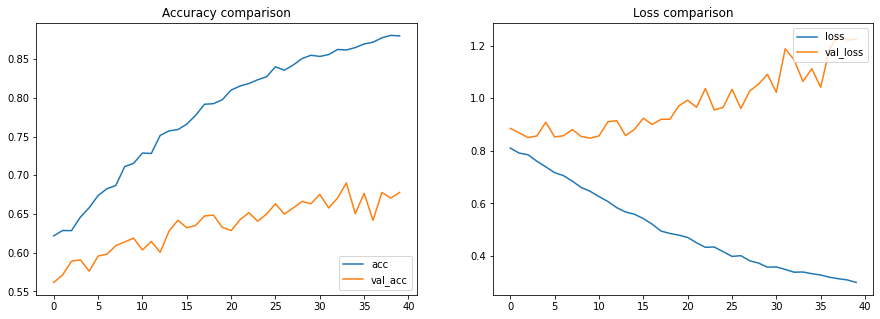

In [7]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

## **모델 평가**

In [16]:
X_test = np.load('./X_test_128.npy',allow_pickle=True)/255
y_test = np.load('./y_test_128.npy',allow_pickle=True)
y_test = np.array(y_test).astype(np.float32)
trs.evaluate(X_test, y_test)

16/16 [==============================] - 83s 5s/step - loss: 1.4622 - accuracy: 0.6348


[1.4622313976287842, 0.634765625]

In [17]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [18]:
y_pred_enc = trs.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
        
res

16/16 [==============================] - 80s 5s/step


,Type 1,Type 2,Type 3
Type 1,32,40,15
Type 2,11,211,43
Type 3,2,76,82
